## Loan Application Data

In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Efficient arrays
import numpy as np
# Dataframes
import pandas as pd
# Plotting and visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc

import warnings
warnings.filterwarnings('ignore')

In [3]:
linkwhite='https://drive.google.com/open?id=1-Z-m5MHuqMpFAK9Mq0EiekeOqauw_0d9'
fluff, id2 = linkwhite.split('=')
print (id2)

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('loan_data.csv')  
dataset = pd.read_csv('loan_data.csv')
dataset.head()

1-Z-m5MHuqMpFAK9Mq0EiekeOqauw_0d9


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = dataset.copy()

In [5]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [6]:
df.shape

(307511, 122)

### Handle outliers

In [7]:
def handle_outliers(df, col_name, threshold_max, threshold_min=0, value_to_be_replaced = np.nan):
    '''
    Our function handles outliers in the dataframe 
    Any value that is greater than threshold_max or less than threshold_min is 
    considered an outlier
    All outliers will be replaced with value_to_be_replaced
    INPUTS:
    df - Dataframe
    col_name - Column name for which outliers need to be handled
    threshold_min - Any value < will be considered an outlier
    threshold_max - Any value > will be considered an outlier
    value_to_be_replaced - All outliers will be replaced by this value
    OUTPUT:
    df - Dataframe after outliers are handled
    '''
    
    # Any value above or below threshold will be considered outliers
    is_outlier = (df[col_name] > threshold_max) | (df[col_name] < threshold_min)
    df_anomalous = df[is_outlier]
    num_of_outlier_rows = len(df_anomalous.index)
    
    if num_of_outlier_rows > 0:
        # Print unique outlier values
        outliers = df_anomalous[col_name].unique()
        print("List of unique outlier values in '{}' column, as found: {}".format(col_name, str(outliers)))
        
        # Replace all outlier values
        df.loc[is_outlier, col_name] = value_to_be_replaced
        print('Number of rows updated: ', str(num_of_outlier_rows))
    else:
        print("No outlier found for column '{}'.".format(col_name))
    
    del df_anomalous
    gc.collect()
    
    return df

In [8]:
def select_data_by_values(df, col_name, valid_values):
    '''
    Our function selects those rows where value under col_name 
    belongs to valid_values
    INPUTS:
    df - Dataframe
    col_name - Column name for which outliers need to be handled
    valid_values - List of valid values supported
    OUTPUT:
    df - Dataframe after outliers are handled
    '''
    
    rows_before = len(df.index)
    df = df[df[col_name].isin(valid_values)]
    rows_after = len(df.index)
    
    # Print sound messages
    rows_filtered = rows_before - rows_after
    if rows_filtered > 0:
        print('Number of rows excluded: ', str(rows_filtered))
    else:
        print("No outlier found for column '{}'.".format(col_name))
    
    return df

Review of independent variables descriptions, the following variables will be investigated further for any possible outlier values:

* DAYS_BIRTH
* DAYS_EMPLOYED
* OWN_CAR_AGE
* REGION_RATING_CLIENT_W_CITY
* REGION_RATING_CLIENT
* AMT_INCOME_TOTAL
* CODE_GENDER

Primarily, the review will be on invalid values

>For example, the age of client applying for a loan cannot > 90 years, etc

DAYS_BIRTH
>The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application

Any negative value < 90 years or > 0 will be outlier

In [9]:
min_days_birth = -32850
max_days_birth = 0

In [10]:
var_col = handle_outliers(
    df, 'DAYS_BIRTH', max_days_birth, min_days_birth
)

No outlier found for column 'DAYS_BIRTH'.


DAYS_EMPLOYED
>Lets identify anomalous values in 'DAYS_EMPLOYED'. 'DAYS_EMPLOYED' contains number of days relative to the application when a client was employed. Values will be negative or zero. Postive value indicates future date and is an outlier

Lets assume that a client can be employed for maximum 60 years before date of loan application

In [11]:
min_valid_employment_days = -21900
max_valid_employment_days = 0

In [12]:
var_col = handle_outliers(
    df, 'DAYS_EMPLOYED', max_valid_employment_days, min_valid_employment_days
)

List of unique outlier values in 'DAYS_EMPLOYED' column, as found: [365243]
Number of rows updated:  55374


OWN_CAR_AGE
>age of car > 80 or < 0 will be considered an outlier

In [13]:
max_car_age = 80

In [14]:
var_col = handle_outliers(
    df, 'OWN_CAR_AGE', max_car_age
)

List of unique outlier values in 'OWN_CAR_AGE' column, as found: [91.]
Number of rows updated:  2


REGION_RATING_CLIENT_W_CITY
>Rating of region where clients live cannot be negative
 
Negative rating are outliers

In [15]:
max_rating = 999

In [16]:
var_col = handle_outliers(
    df, 'REGION_RATING_CLIENT_W_CITY', max_rating
)

No outlier found for column 'REGION_RATING_CLIENT_W_CITY'.


REGION_RATING_CLIENT
>Rating of region where clients live cannot be negative 

Negative rating are outliers

In [17]:
max_rating = 999

In [18]:
var_col = handle_outliers(
    df, 'REGION_RATING_CLIENT', max_rating
)

No outlier found for column 'REGION_RATING_CLIENT'.


AMT_INCOME_TOTAL
>Income of client cannot be negative. Client(s) who earn sufficiently high income, are unlkely to apply for loans

Negative or earnings > 1e8 can be considered outliers

In [19]:
max_income = 1e8

In [20]:
var_col = handle_outliers(
    df, 'AMT_INCOME_TOTAL', max_income
)

List of unique outlier values in 'AMT_INCOME_TOTAL' column, as found: [1.17e+08]
Number of rows updated:  1


CODE_GENDER

Sex will be either:

* 'M' for male
* 'F' for female

In [21]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [22]:
valid_sex = ['M','F']

In [23]:
var_col = select_data_by_values(
    df, 'CODE_GENDER', valid_sex
)

Number of rows excluded:  4


### Analysis of missing values

In [24]:
print("Number of rows having NULL in 'TARGET' variable: ", str(df['TARGET'].isna().sum()))

Number of rows having NULL in 'TARGET' variable:  0


In [25]:
def plot_missing_data(df):
    '''
    Our function accepts a dataframe
    For this dataframe, the function
    1. computes percentage of missing value for each column, and
    2. plots the data on a graph
    INPUT:
    df - Dataframe on which missing data % needs to be computed and plotted
    OUTPUT: 
    Plot on missing data
    '''
    
    fig = plt.figure(figsize=(20,6))
    
    # Percentage of missing values
    missing = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
    
    ax = sns.pointplot('index', 0, data=missing)
    plt.xticks(rotation=90, fontsize=7)
    plt.title('Percentage of missing values in the data')
    plt.ylabel('PERCENTAGE')
    plt.xlabel('VARIABLES')
    ax.set_facecolor('k')
    fig.set_facecolor('lightgrey')

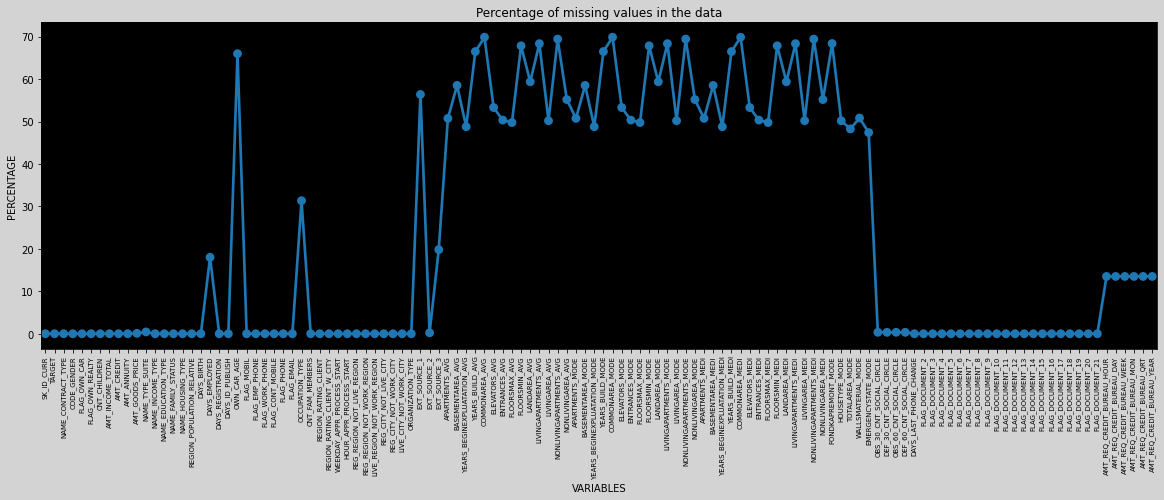

In [26]:
plot_missing_data(df)

In [27]:
# Preview percentage of NULL in each column
missing_val = ((df.isna().sum()) / len(df.index)).sort_values(ascending=False)
missing_val = missing_val[missing_val > 0]
print(missing_val * 100)

COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
                              ...    
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
AMT_INCOME_TOTAL             0.000325
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 69, dtype: float64


There are variables where more than 60% of data is missing 

*There are 2 ways of handle missing data*:

1. **Imputation** i.e. fill up those missing values
2. **Drop variables** were most of the values are missing

**Dropping variables can be risky and may impair model creation**

As of now, we shall keep all variables

### Encode categorical variables

These variables contain a finite number of categories or distinct groups

Lets preview the distribution of data types in our dataframe

In [28]:
df.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [29]:
df.select_dtypes('O').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Strategy for encoding

We'll use Label Encoding and OHE for categorical variables

Advantage of label encoding is that no new column is created. However, this encoding gives the categories arbitrary ordering. The value assigned to each of the categories is random

On other hand, OHE creates a new column for each unique category in a categorical variable. Hence, this encoding increases the dimentionality of the data

Therefore, our strategy will be as follows:

* Apply Label Encoding, if number of categories in a categorical variable, and = to 2
* Apply OHE, if number of categories in a categorical variable > 2

NOTE: 

*For categorical variables, the number of unique values (or, categories) is always >= 2*

In [30]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Create Label Encoder object
le = LabelEncoder()
encoded_col_count = 0

# Iterate through the variables
for col in df:
    if df[col].dtype == 'O':
        # If 2 unique categories
        if len(list(df[col].unique())) == 2:
            # Fit and transform variables
            df[col] = le.fit_transform(df[col])
            # Keep track of how many variables were Label Encoded
            encoded_col_count += 1
            
print('Total number of variables that were label encoded: ', str(encoded_col_count))

Total number of variables that were label encoded:  3


OHE

In [31]:
df = pd.get_dummies(df)

In [32]:
print('df shape: ', df.shape)

df shape:  (307511, 243)


## EDA

TARGET variable class distribution

In [33]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [34]:
def plot_distribution_of_output_labels(df, plot_title, output_col=None):
    '''
    Our function plots distribution of output class in a pie-chart
    INPUT:
    df: Dataframe
    plot_title: Title of the plot
    output_col: The column containing output classes
    OUtPUT: 
    pie-chart on output classes
    '''

    plt.figure(figsize=(14,7))
    plt.subplot(121)
    if(output_col is None):
        df.value_counts().plot.pie(
            autopct = '%1.2f%%', colors=sns.color_palette('muted'), startangle=60,
            labels = ['Repayer', 'Defaulter'],
            wedgeprops = {'linewidth':2, 'edgecolor': 'k'}, explode=[.1,0], shadow=True)
    else:
        df[output_col].value_counts().plot.pie(
            autopct = '%1.2f%%', colors=sns.color_palette('muted'), startangle=60,
            labels = ['repayer', 'defaulter'],
            wedgeprops = {'linewidth':2, 'edgecolor':'k'}, explode=[.1,0], shadow=True)
    
    plt.title(plot_title)

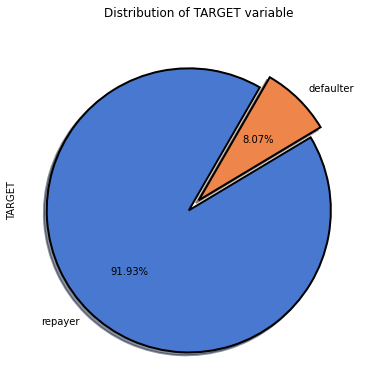

In [35]:
plot_distribution_of_output_labels(df, 'Distribution of TARGET variable', 'TARGET')

### Feature Correlation with TARGET class

Before we proceed further, we need to change one part of the data. DAYS_BIRTH is client's age in days relative to the application, and is a negative number

Here onwards, we shall only consider the number for this age and not negative sign

In [36]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])

In [37]:
corrs = df.corr()
corrs['TARGET'].sort_values(ascending=True)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
                                          ...   
NAME_INCOME_TYPE_Working                0.057481
REGION_RATING_CLIENT                    0.058899
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_EMPLOYED                           0.074958
TARGET                                  1.000000
Name: TARGET, Length: 243, dtype: float64

### Top 4 positive correlations with 'TARGET' class: 

* DAYS_EMPLOYED
* REGION_RATING_CLIENT_W_CITY
* REGION_RATING_CLIENT
* NAME_INCOME_TYPE_Working

### Top 4 negative correlations with 'TARGET' class: 

* EXT_SOURCE_3 
* EXT_SOURCE_2 
* EXT_SOURCE_1 
* DAYS_BIRTH

Lets define a reusable function, to draw kernel density estimation plot of these variables with TARGET class

In [38]:
del corrs
gc.collect()

20316

In [39]:
def kde_plot_with_target(col_name):
    '''
    Our function generates (kde) plot of input column with the TARGET
    INPUT:
    col_name: Name of the input column
    OUTPUT:
    kde plot with TARGET
    '''

    plt.figure(figsize = (10,8))

    # kde plot of loan applications that were repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 0, col_name], label='Repaid in time')

    # kde plot of loans applications that were NOT repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 1, col_name], label='Difficulty in repayment')

    # Labeling of plot
    plt.xlabel(col_name) 
    plt.ylabel('Density') 
    plt.title('Distribution of {} by TARGET'.format(col_name))

#### Days of employment
Has the highest postive correlation with TARGET class

Lets preview the histogram for this data. This data shows how many days before the loan application the client started current employment. The time is only relative to the application, and thus is negative

Text(0.5, 0, 'Daya of employment')

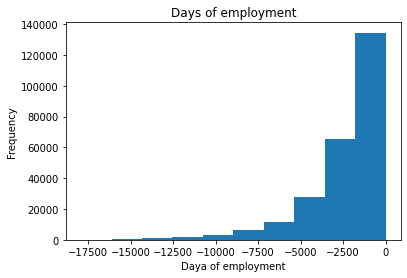

In [40]:
df['DAYS_EMPLOYED'].plot.hist(title='Days of employment')
plt.xlabel('Daya of employment')

The distribution shows the clients' that are newly employed are *MORE* likely to apply for loan(s)

Lets observe kde plot with TARGET class

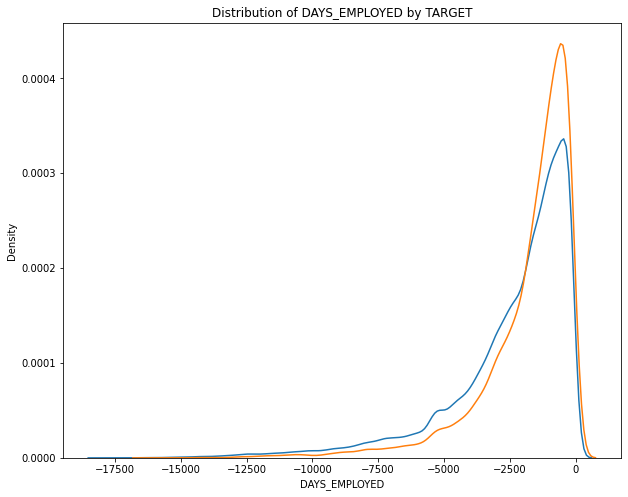

In [41]:
kde_plot_with_target('DAYS_EMPLOYED')

This plot isn't that conclusive. Its skewed because maximum borrowers have very less days in employment. So, both chance of repayment and risk of defaulting are high when days in employment are low

#### Ratings of client regions
REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT contain second and third highest positive correlations with TARGET class

Text(0.5, 0, 'Region Rating with City')

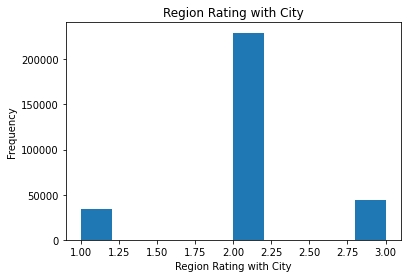

In [42]:
df['REGION_RATING_CLIENT_W_CITY'].plot.hist(title='Region Rating with City')
plt.xlabel('Region Rating with City')

Text(0.5, 0, 'Region Rating')

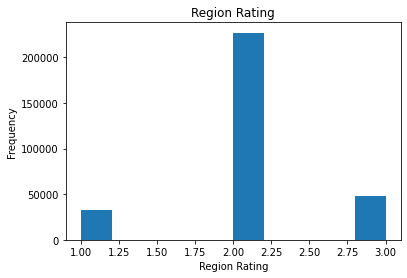

In [43]:
df['REGION_RATING_CLIENT'].plot.hist(title='Region Rating')
plt.xlabel('Region Rating')

Both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY contain almost identical data

The regions having rating between 2 and 2.25 contains the most number of laon clients

Lets preview kde plot for these variables

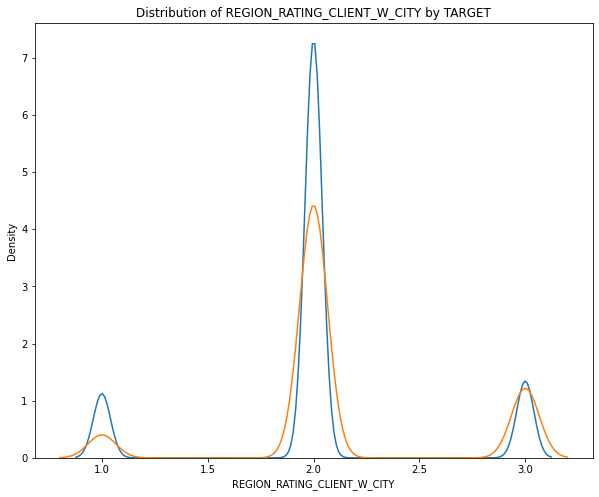

In [44]:
kde_plot_with_target('REGION_RATING_CLIENT_W_CITY')

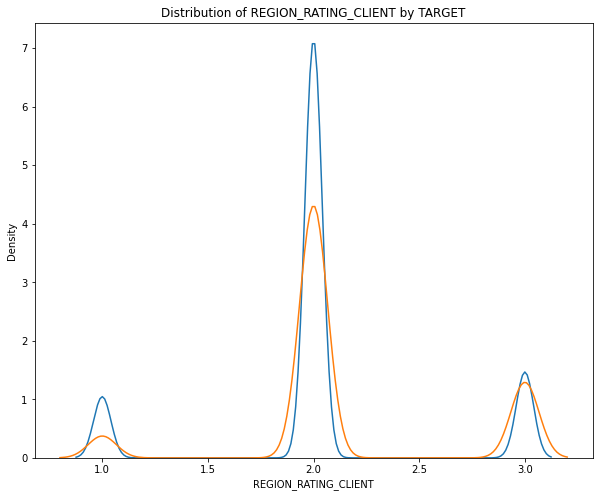

In [45]:
kde_plot_with_target('REGION_RATING_CLIENT')

As expected from the histograms, densities for both repayment and defaulting are high for the regions having rating around 2.0

We can see a spike for regions having rating close to 3.0



#### Score from External Data Source

* EXT_SOURCE_1 
* EXT_SOURCE_2 
* EXT_SOURCE_3 

has the highest negative correlations with TARGET class

Lets see kde plot of these variables with the TARGET class

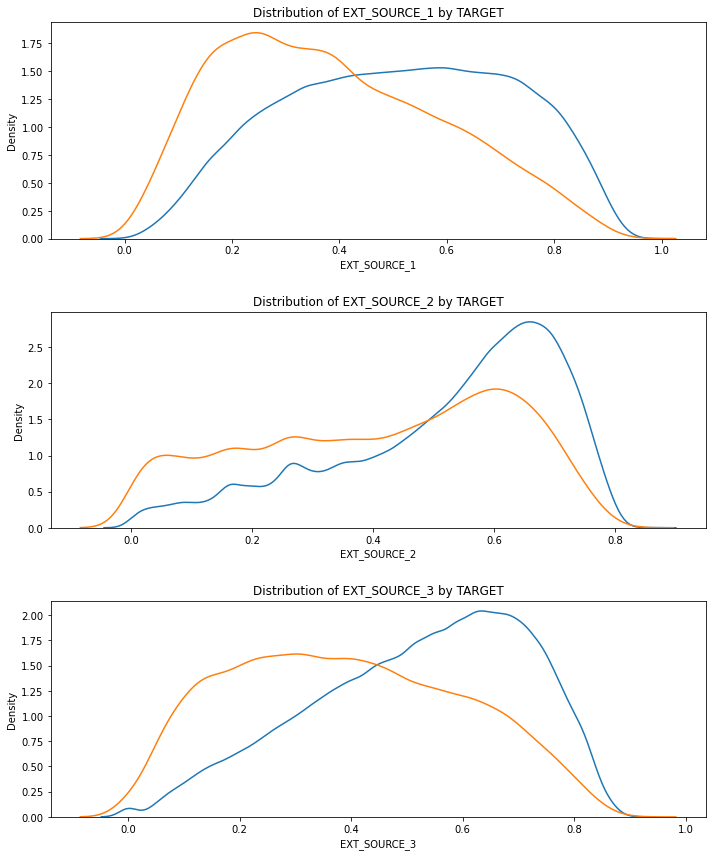

In [46]:
plt.figure(figsize=(10,12))

# Iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Create a new subplot for each source
    plt.subplot(3,1,i + 1)
    # Plot loans repaid
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], label='Repaid in time')
    # Plot loans that were NOT repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], label='Difficulty in repayment')
    
    # Label the plots
    plt.title('Distribution of {} by TARGET'.format(source))
    plt.xlabel(source) 
    plt.ylabel('Density')
    
plt.tight_layout(h_pad=2.5)

Risk of difficulty in repayments are high when ratings from external sources 1 and 3 are low. Simialrly, chances of repayment is higher when ratings from these sources are higher 

Effect of rating from second external source on TARGET variable is not that conclusive

#### Client's age

DAYS_BIRTH has fourth highest negative correlation with TARGET variable

That means, as the client gets older, they are less likely to default on their loan(s)

Text(0, 0.5, 'Count')

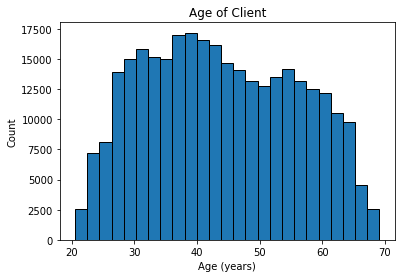

In [47]:
# Plot the distribution of ages in years
plt.hist(df['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)') 
plt.ylabel('Count')

We observe from this distribution, most borrows are aged around 40 years old

To visualize the effect of age on the TARGET variable, we'll make a kde plot

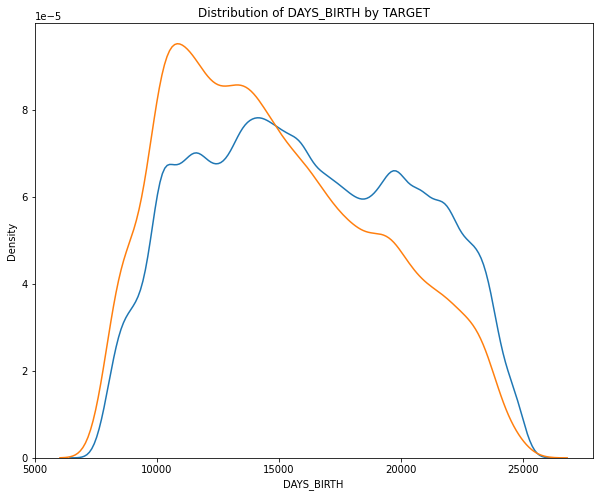

In [48]:
kde_plot_with_target('DAYS_BIRTH')

As shown in the curve above, younger applicants are more likely to not repay thier loans